In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import expipe
import exdir
import os
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import data_processing as dp
from utils import *

In [3]:
# change matplotlib default figsize and fonts
plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
# get actions
project_path = dp.project_path()
project = expipe.get_project(project_path)

### Initialise data loader

In [5]:
# remove leading and trailing recording data
t_start = 0
t_stop = None # None => don't remove anything

max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position

box_size = [1.0, 1.0]
bin_size=0.02
smoothing = 0.05

data_loader = dp.Data(
    position_sampling_rate=position_sampling_rate, 
    position_low_pass_frequency=position_low_pass_frequency,
    box_size=box_size, bin_size=bin_size, stim_mask=False, baseline_duration=None,
)

identify_neurons = project.require_action('identify-neurons')
identify_neurons = pd.read_csv(identify_neurons.data_path() / "units.csv")

### Load data (tracking and spikes)

In [6]:
# select actions to include
actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']

# load all tracking data (dict)trial x (dict)track_quantities x (array)time
tracking = {action_id:data_loader.tracking(action_id) for action_id in actions}

# process tracking
t_start, t_stop = 0, 1200
for action_id in tracking:
    # transform coordinates
    newx, newy = transform_coordinates(**tracking[action_id])
    tracking[action_id]['x'] = newx
    tracking[action_id]['y'] = newy
    # truncate recordings
    tracking[action_id].update(truncate_tracking_dict(tracking[action_id], t_start, t_stop))


# load all spikes data (dict)trial x (dict)unit_id x spike_train
# and use identify-neurons to assign unique IDs to each unit
spikes = {}
for action_id in tqdm.tqdm(actions):
    spikes[action_id] = {}
    channel_grps = dp.get_channel_groups(data_loader.data_path(action_id))
    action_mask = identify_neurons['action'] == action_id
    for channel_grp in channel_grps:
        spike_train = data_loader.spike_trains(action_id, channel_grp)
        for unit_id in spike_train:
            unique_unit_id_idx = (identify_neurons['unit_name'] == unit_id) & action_mask
            unique_unit_id = identify_neurons['unit_id'][unique_unit_id_idx].item()
            spikes[action_id][unique_unit_id] = truncate_spikes(spike_train[unit_id], tracking[action_id]["t"])
        # load units and "flatten" channel_grps dimension. - assuming units are unique OR duplicates across channels
        #spikes[action_id].update(data_loader.spike_trains(action_id, channel_grp))
        
# find persistent units (intersection over trials)
punits = persistent_units(spikes)
punits

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


['26d4502a-4d89-49a0-9214-1646ce5c2595',
 'bfa84900-db4a-416a-a9b0-3378262d8ca3',
 'cb7c405a-c65e-4f34-acfd-db341c9f9bdc',
 'bc7338b1-0ac4-4019-a8f6-1f6b0711bcc8',
 '13da002c-9870-42db-87e0-0f6ff9b05bd2',
 'eac979e3-01c5-44a0-a1f5-21a5540a010b',
 'a7e4293f-b726-4f91-9582-1444f2af8487',
 '87d8a331-3b4b-404b-9bc4-584381d5da7e',
 'a12b5b5c-bc3b-4669-bd8f-5f58013f008a',
 '362b87d9-b8cd-4ac9-bf7c-c00826ac5b19',
 '18141e4f-f245-4d81-a2b5-8d071dfa0457',
 '35eea67f-545f-4114-aa21-4f0e45fb94eb',
 '9dcbbcc4-df72-489d-85da-70c1cc3ab159',
 '48959fa4-33ea-463a-abc1-7fd13a3b0b52',
 '7c4b7b9a-74f7-46b4-b01f-5d12b0067997']

### Example tracking and ratemap

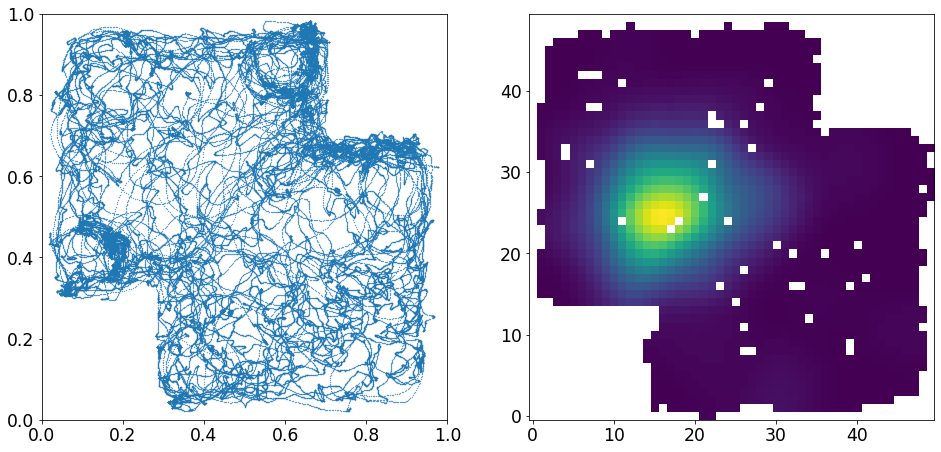

In [7]:
x,y,t,_ = tracking[action_id].values()
spike_times = spikes[action_id][punits[0]]

spatial_map = sp.SpatialMap(x,y,t,spike_times, box_size=box_size, bin_size=bin_size)
ratemap = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=True)

fig,ax = plt.subplots(ncols=2)
ax[0].scatter(x,y,s=0.1)
ax[0].set_aspect('equal')#, adjustable='box')
ax[0].set_xlim([0,1])
ax[0].set_ylim([0,1])
ax[1].imshow(ratemap,origin='lower')

In [8]:
ratemaps = {}
for action_id in tqdm.tqdm(actions):
    ratemaps[action_id] = {}
    x,y,t,_ = tracking[action_id].values()
    for unit_id in spikes[action_id]:
        spike_times = spikes[action_id][unit_id]
        spatial_map = sp.SpatialMap(x,y,t,spike_times, box_size=box_size, bin_size=bin_size)
        ratemap = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=True)
        ratemaps[action_id][unit_id] = ratemap

100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


### (Stability) Correlate 50/50 trail-split rate maps

In [20]:
# Choose which trials to cross-correlate
t2_action_id = ''
t3_action_id = ''
for action_id in actions:
    if trial_id(project.require_action(action_id)) == 't2':
        t2_action_id = action_id
    elif trial_id(project.require_action(action_id)) == 't3':
        t3_action_id = action_id


# do cross correlation
from scipy import ndimage
t2_vs_t3_stability = {'cross': [], 'rot_cross': []}

for unit_id in punits:
    t2_vs_t3_stability['cross'].append(nancorrcoef(ratemaps[t2_action_id][unit_id], ratemaps[t3_action_id][unit_id]))
    rotratemap = ratemaps[t3_action_id][unit_id][::-1,::-1] # 180 degree rotation by flipping on axes
    t2_vs_t3_stability['rot_cross'].append(nancorrcoef(ratemaps[t2_action_id][unit_id], rotratemap))

### Plot (violin) and summarise statistics (Mann-U)

cross vs rot_cross: MannwhitneyuResult(statistic=214.0, pvalue=2.7983495853192978e-05)


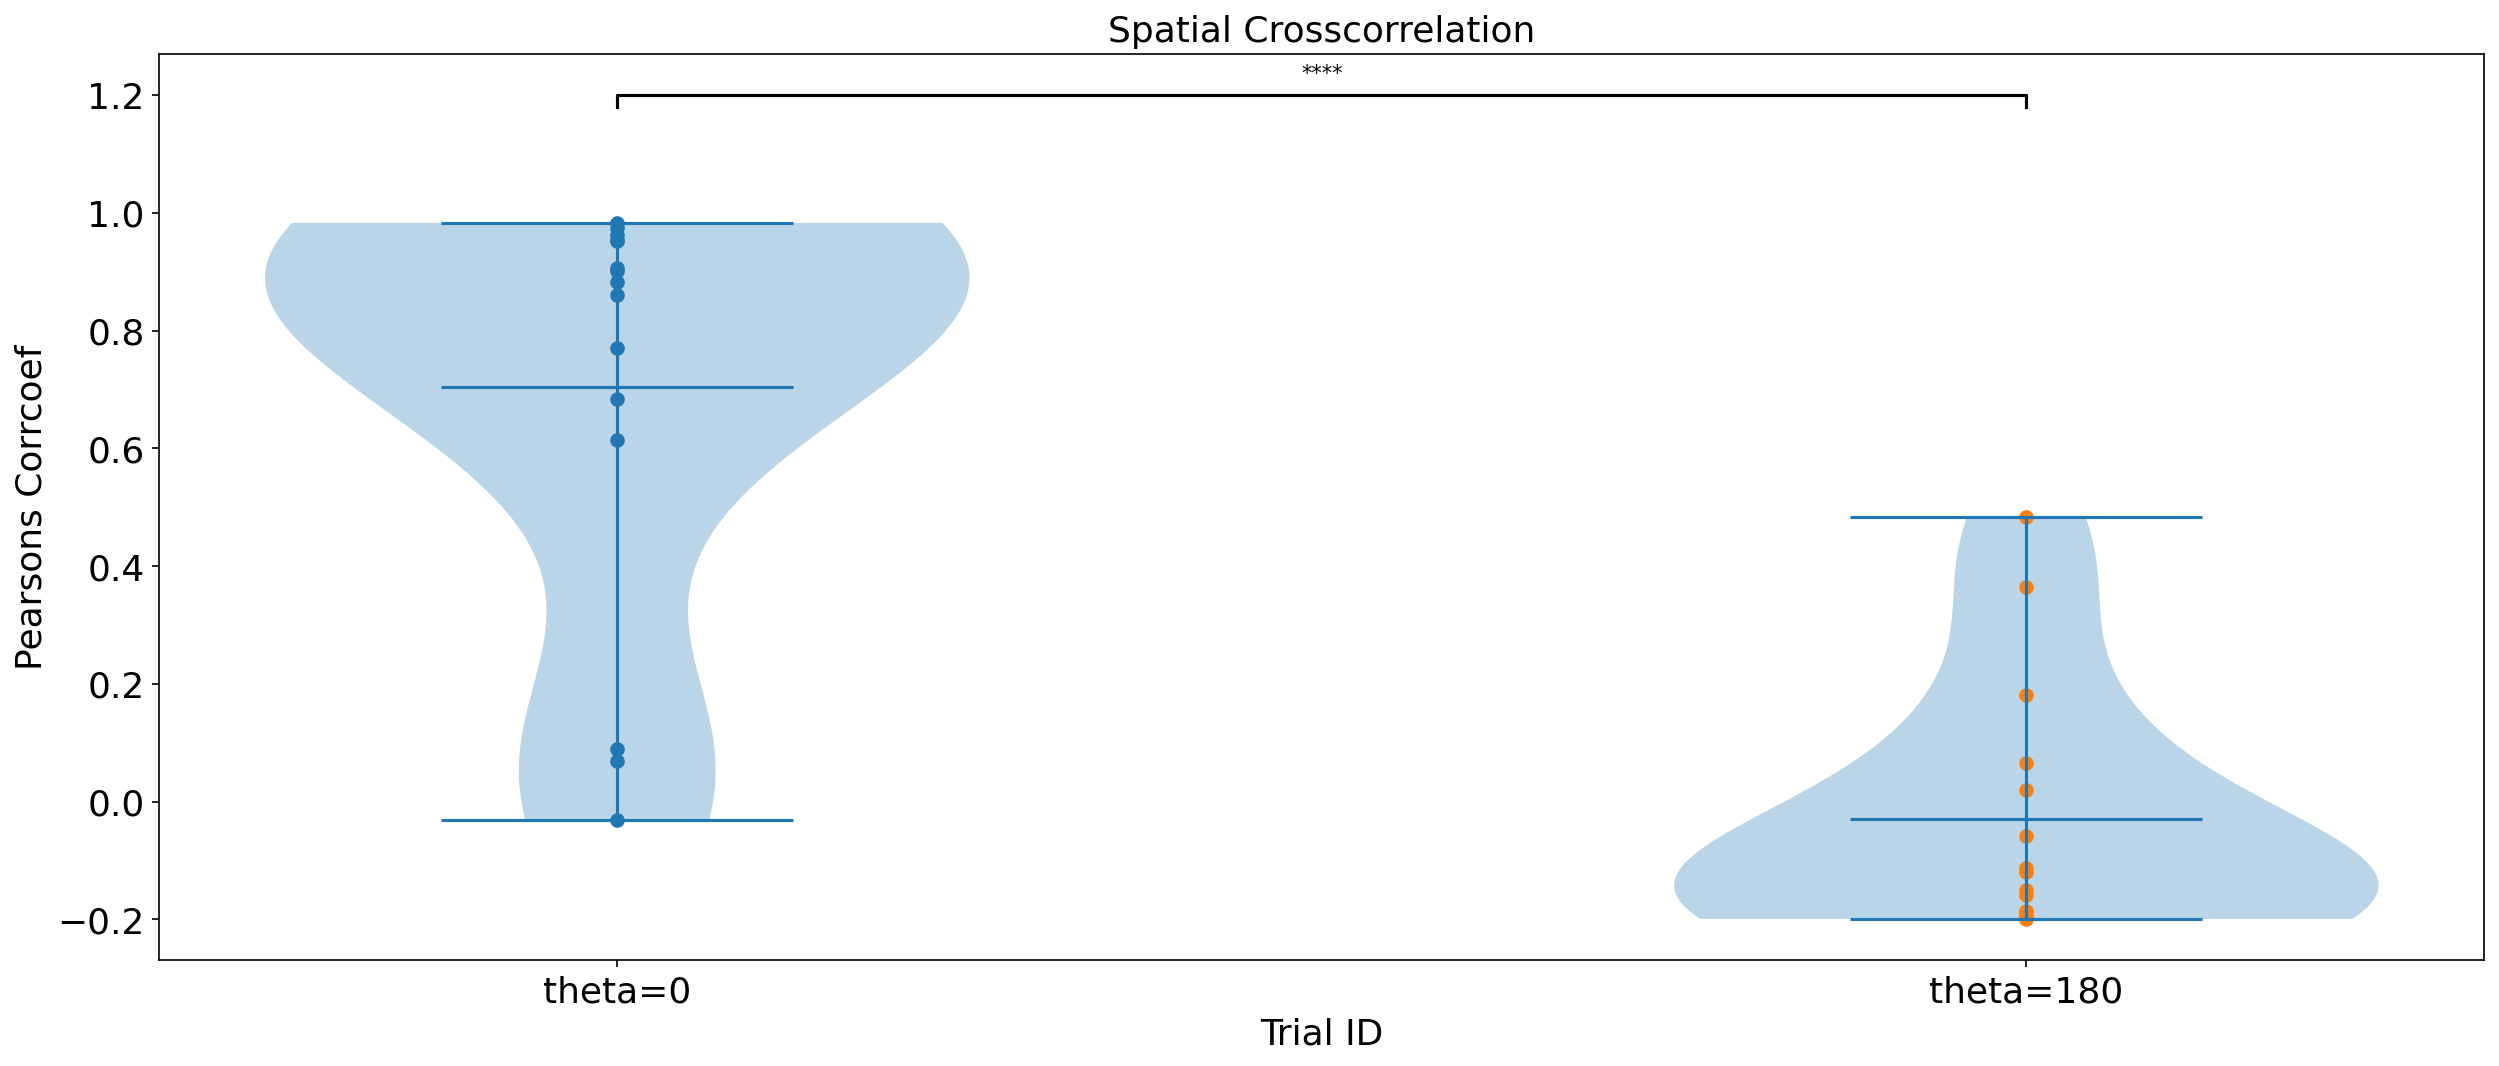

In [10]:
plt.rcParams.update({'figure.dpi': 150, 'legend.frameon': False})
# sns.set_style('white', {'legend.frameon': False})
palette = {'setosa': '#7fc97f', 'versicolor': '#beaed4', 'virginica': '#fdc086'}

fig, ax = plt.subplots(figsize=(20,8))
ax.violinplot(t2_vs_t3_stability.values(), showmeans=True)
#plt.xticks(rotation=45)

# --- plot formatting ---
# add trial labels to x-axes ticks
labels = ['theta=0', 'theta=180']
ticks_locs = np.arange(1, len(labels) + 1)
ax.set_xticks(ticks_locs)
ax.set_xticklabels(labels)

# --- Plot data points in the violin ---
for xtick, stabs in zip(ticks_locs, t2_vs_t3_stability.values()):
    ax.scatter(np.ones(len(stabs))*xtick, stabs)

# set axes and title labels
ax.set_title('Spatial Crosscorrelation')
ax.set_ylabel('Pearsons Corrcoef')
ax.set_xlabel('Trial ID')

def plot_significance(pvalue, x = [0, 1], y=1.2, h=0.02):
    # significance
    if pvalue < 0.0001:
        significance = "****"
    elif pvalue < 0.001:
        significance = "***"
    elif pvalue < 0.01:
        significance = "**"
    elif pvalue < 0.05:
        significance = "*"
    else:
        significance = "ns"

    x1, x2 = x
    plt.plot([x1, x1, x2, x2], [y - h, y, y, y - h], c='k')
    plt.text((x1 + x2) / 2, y + h, significance, ha='center', va='bottom')

    
for i, t_id in enumerate(t2_vs_t3_stability):
    if i == 0:
        baseline = t_id
        continue
        
    mw = scipy.stats.mannwhitneyu(t2_vs_t3_stability[baseline], t2_vs_t3_stability[t_id], alternative='two-sided')
    print(baseline + " vs " + t_id + ":", mw)
    plot_significance(mw.pvalue, [1,i+1], y = 1.1 + (i)*0.1)

plt.savefig('./plots/t2t3-cross-trial-spatial-stability.pdf')

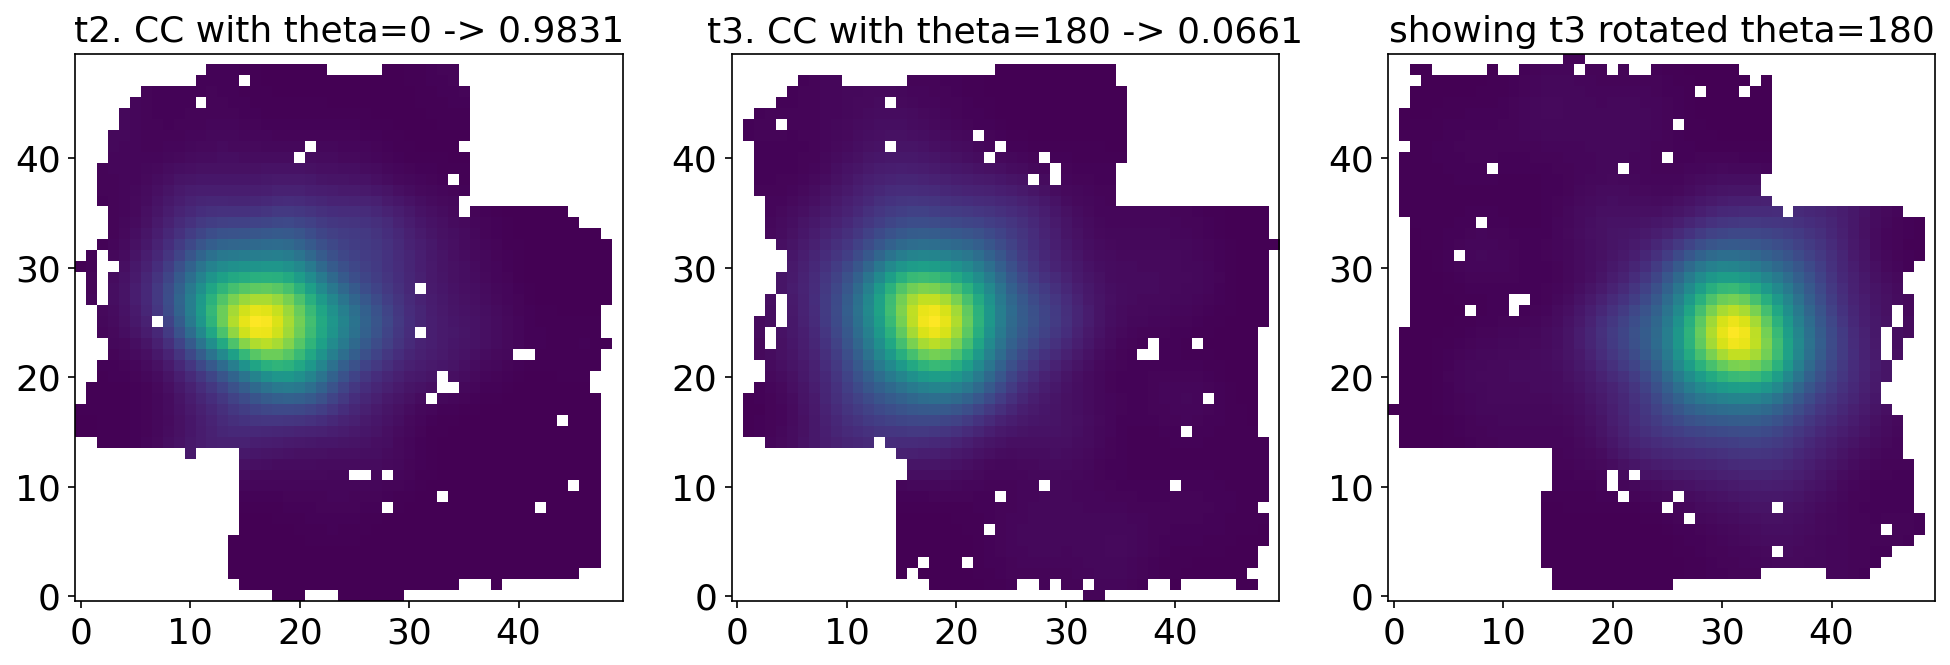

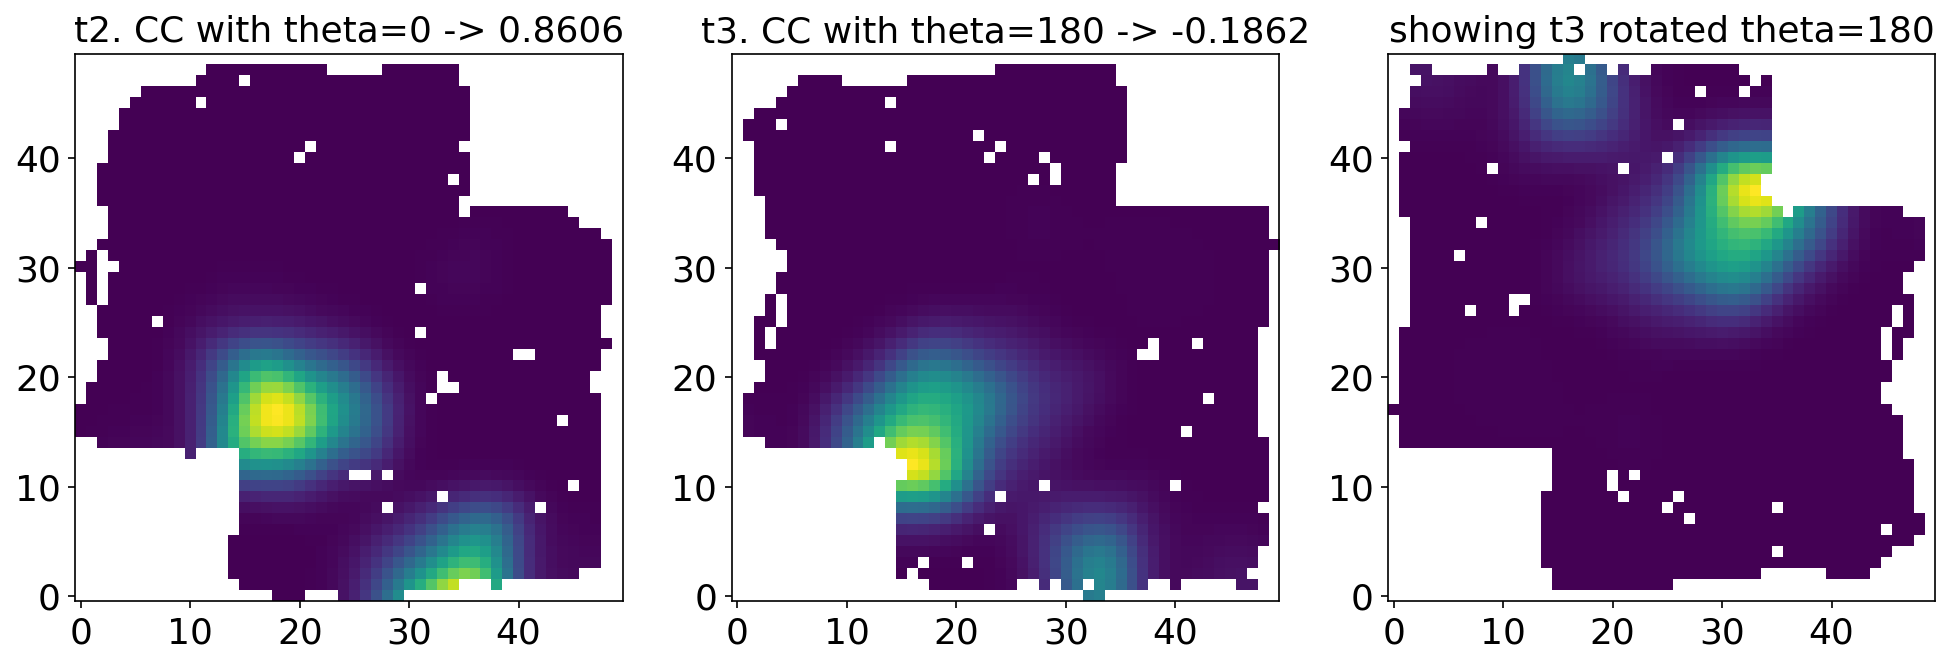

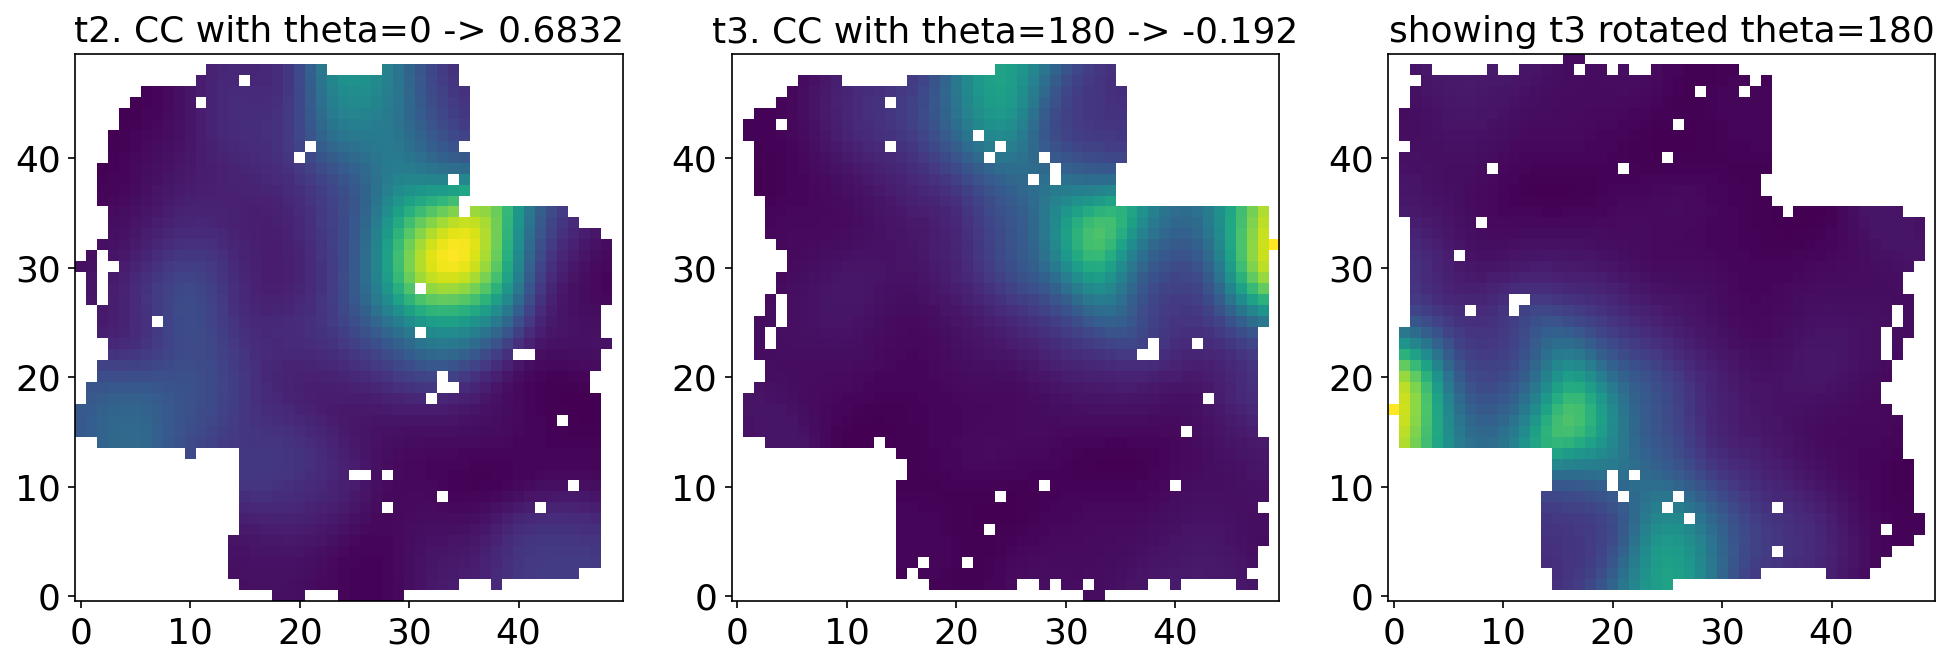

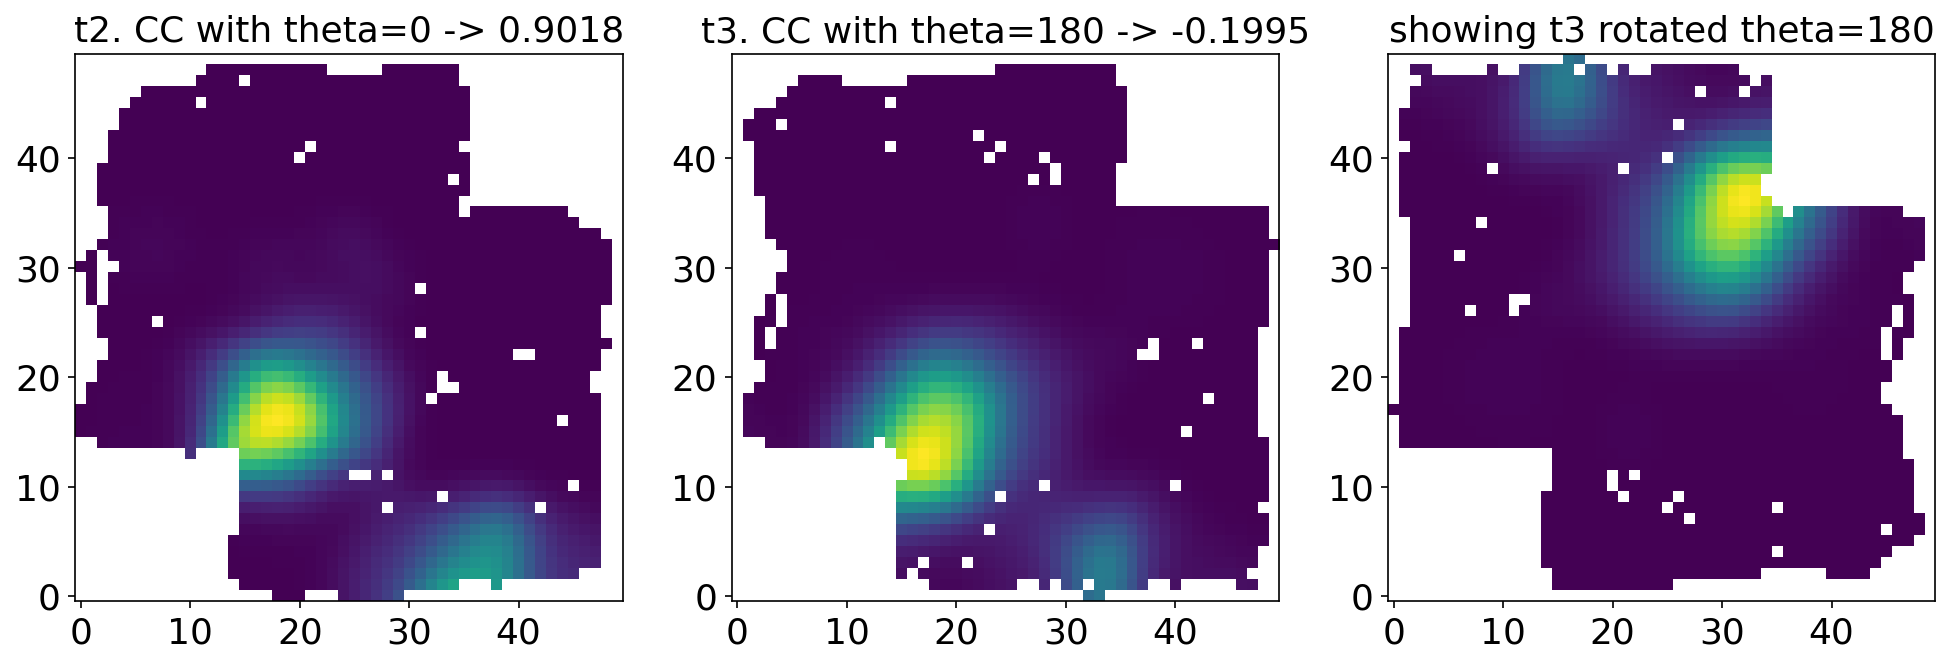

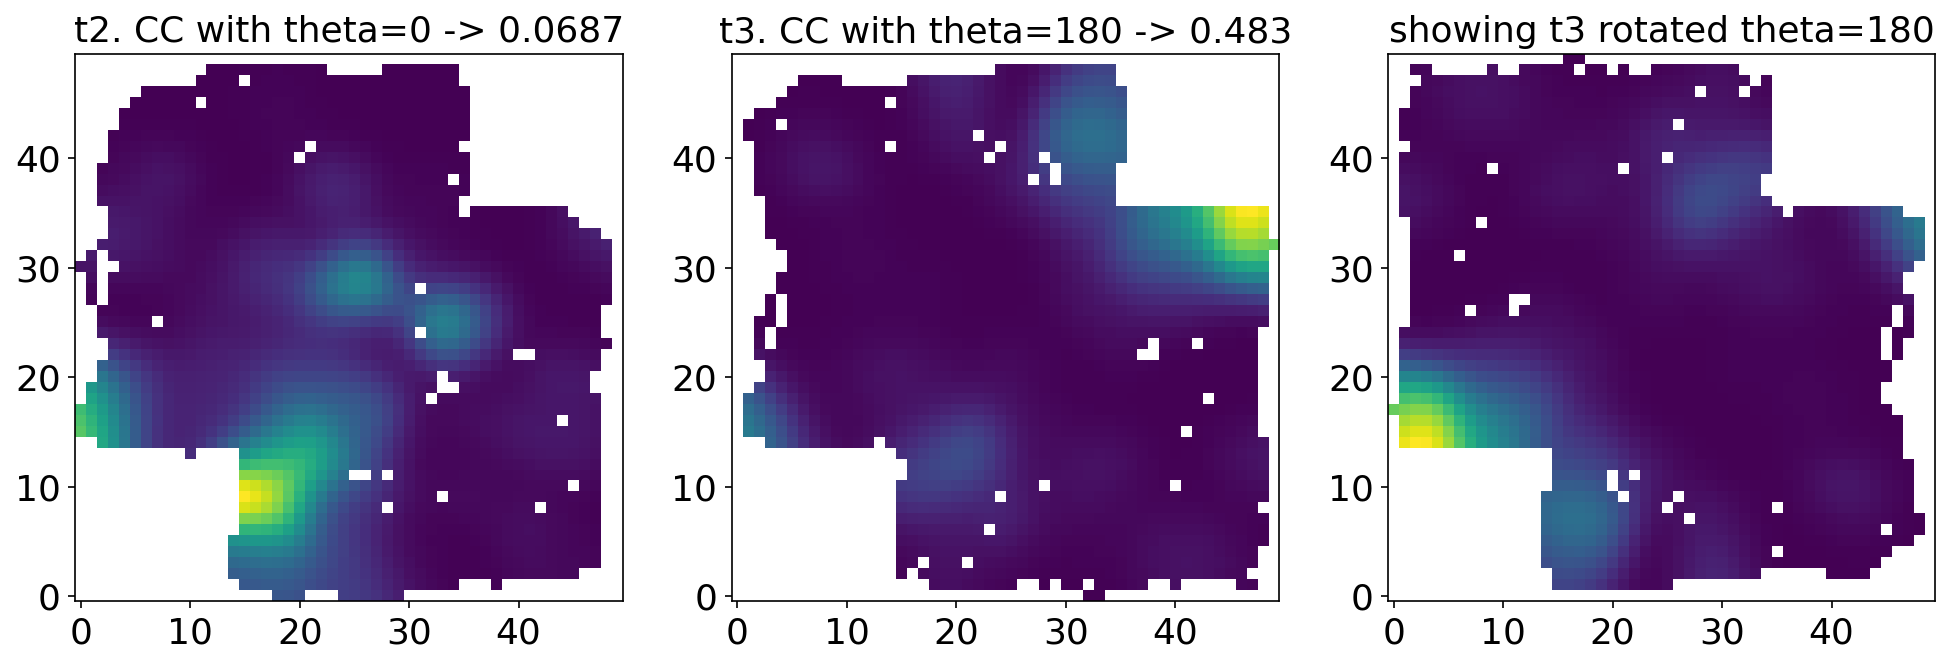

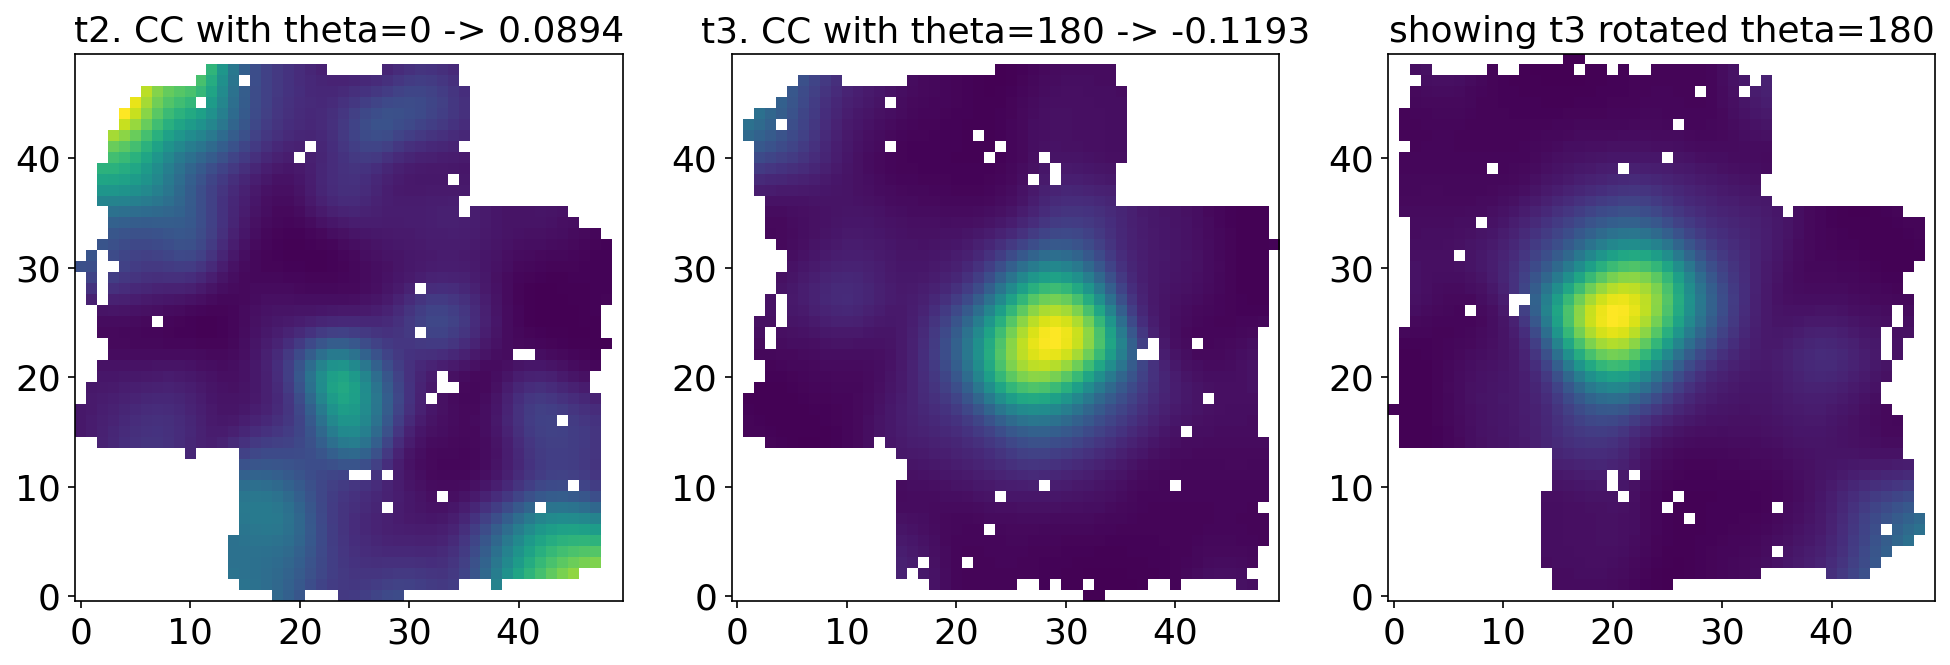

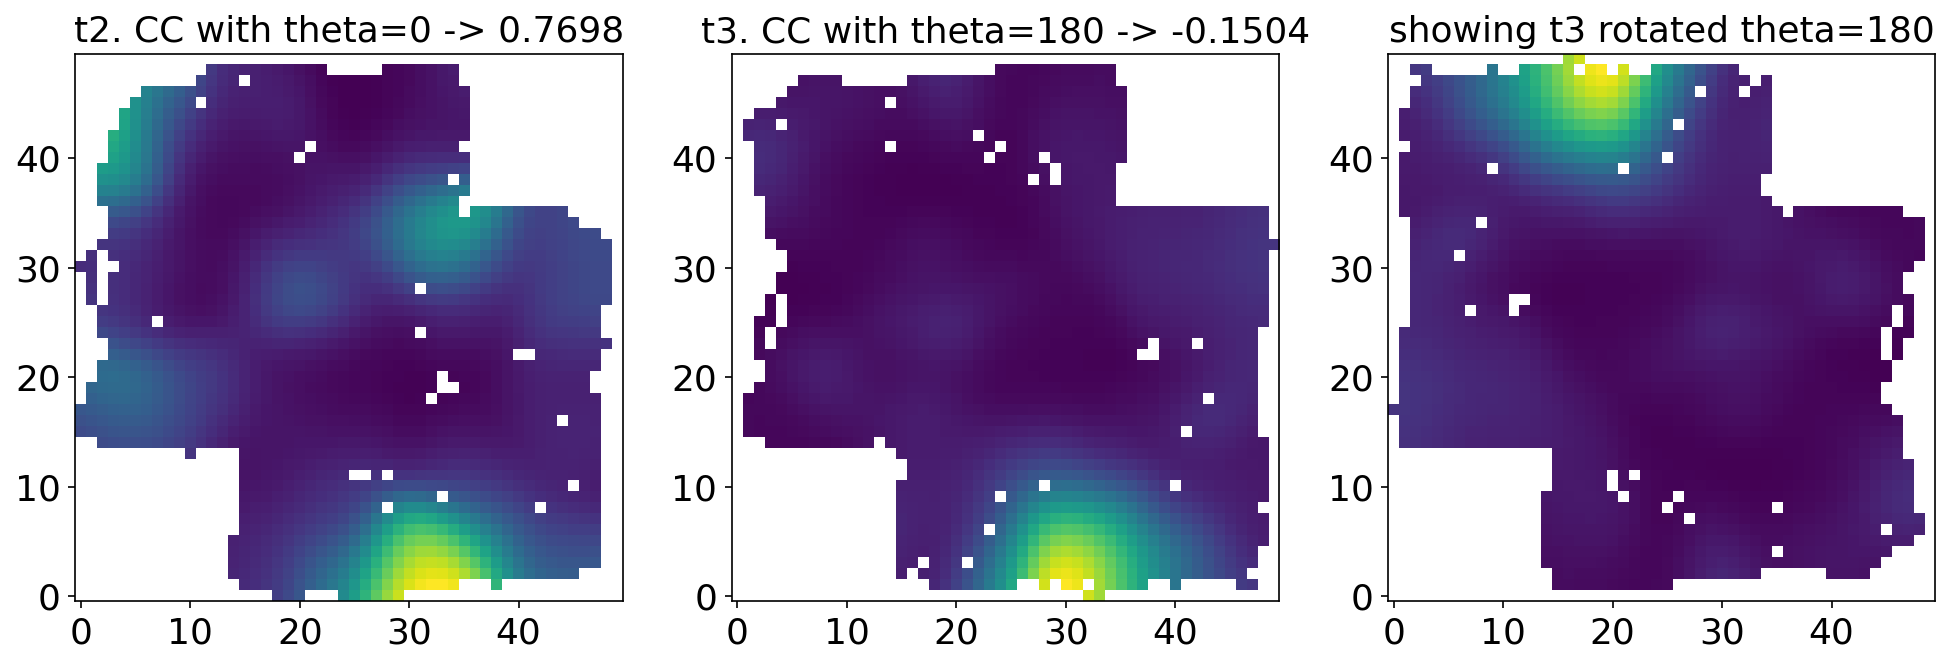

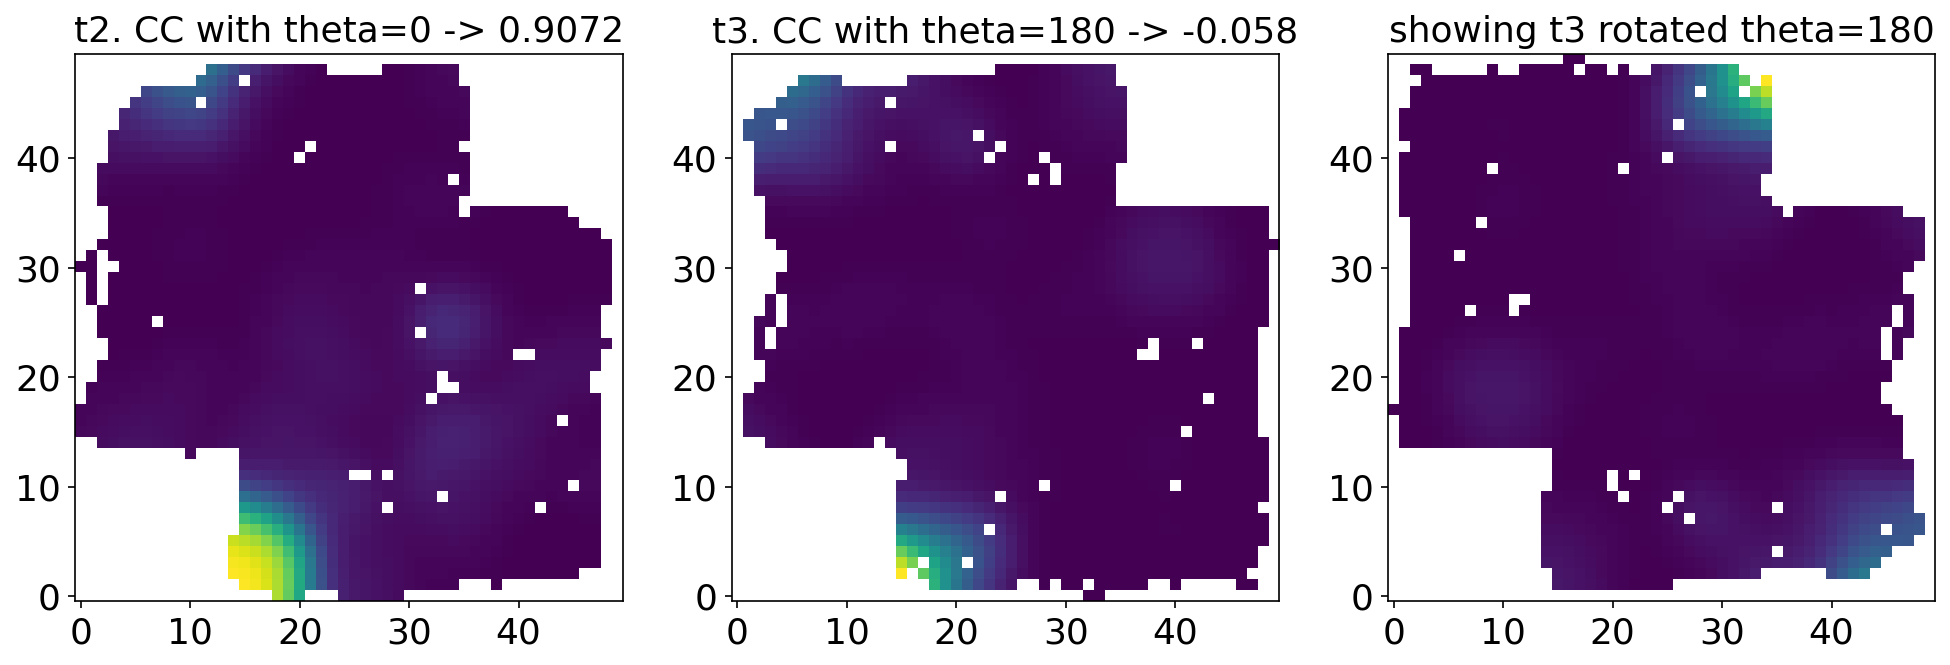

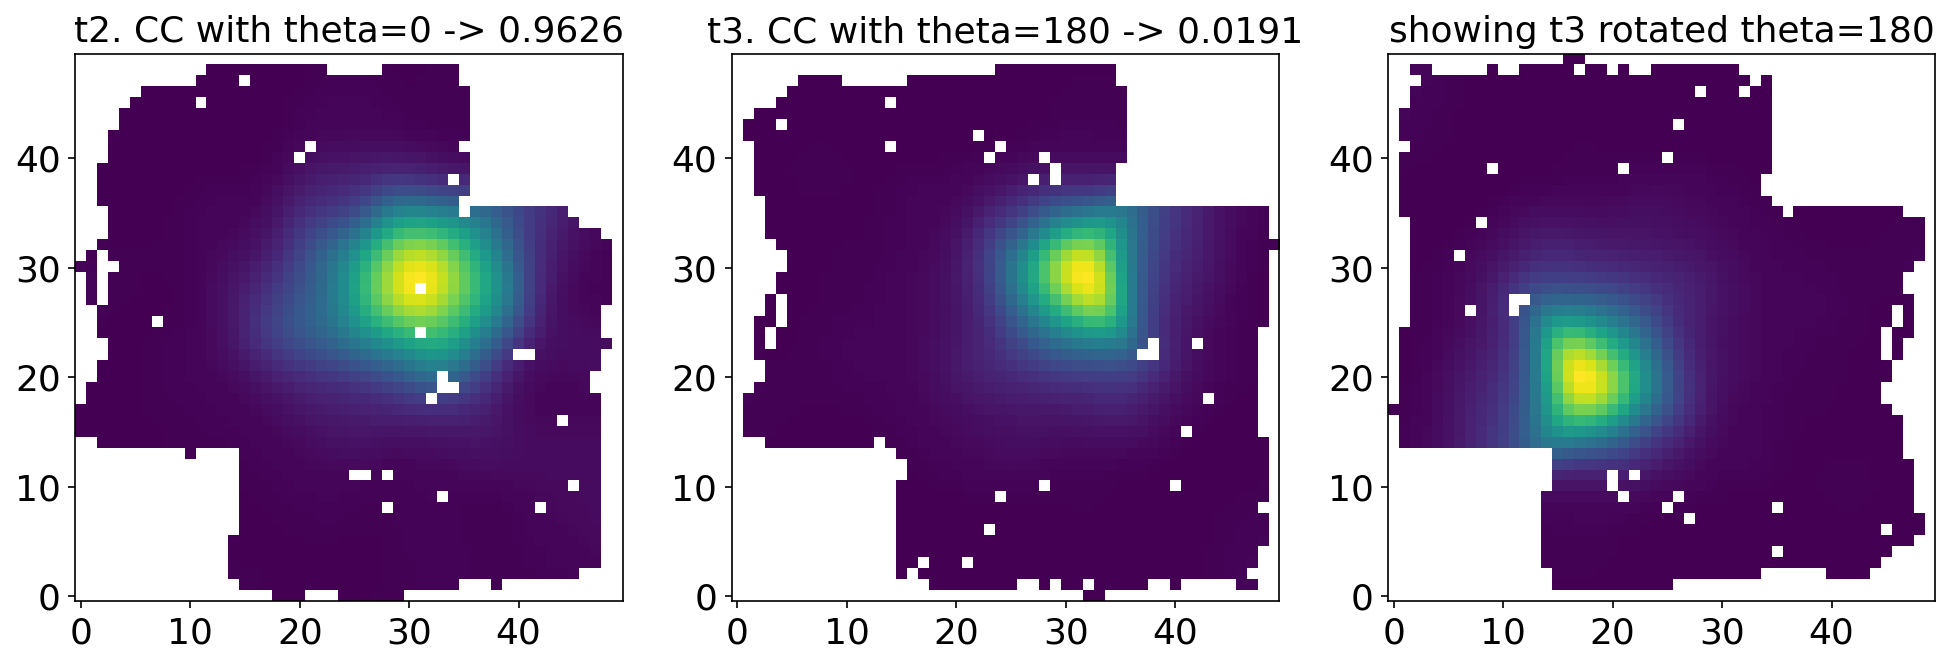

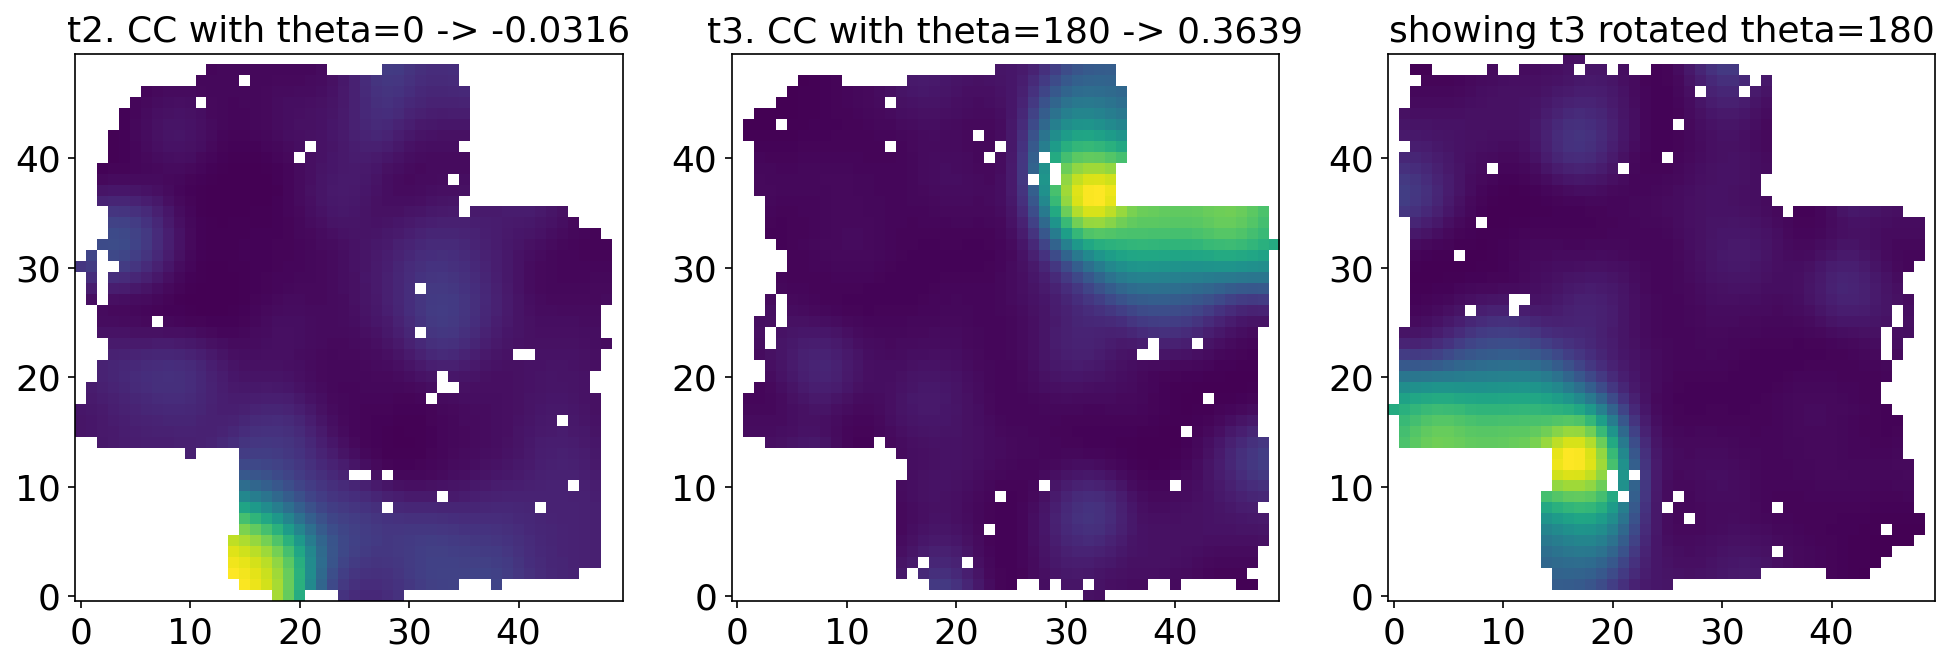

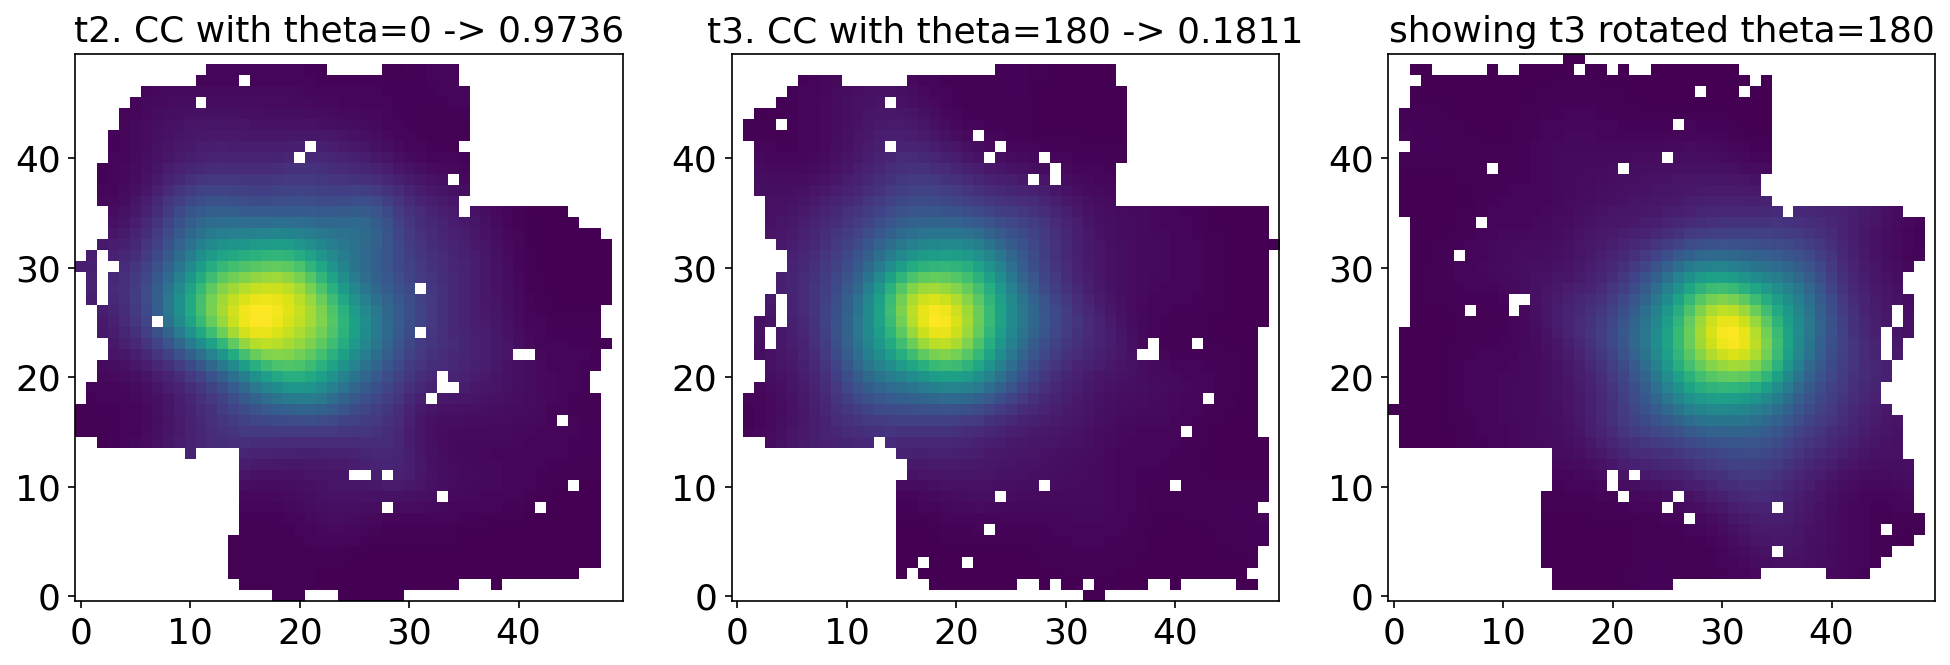

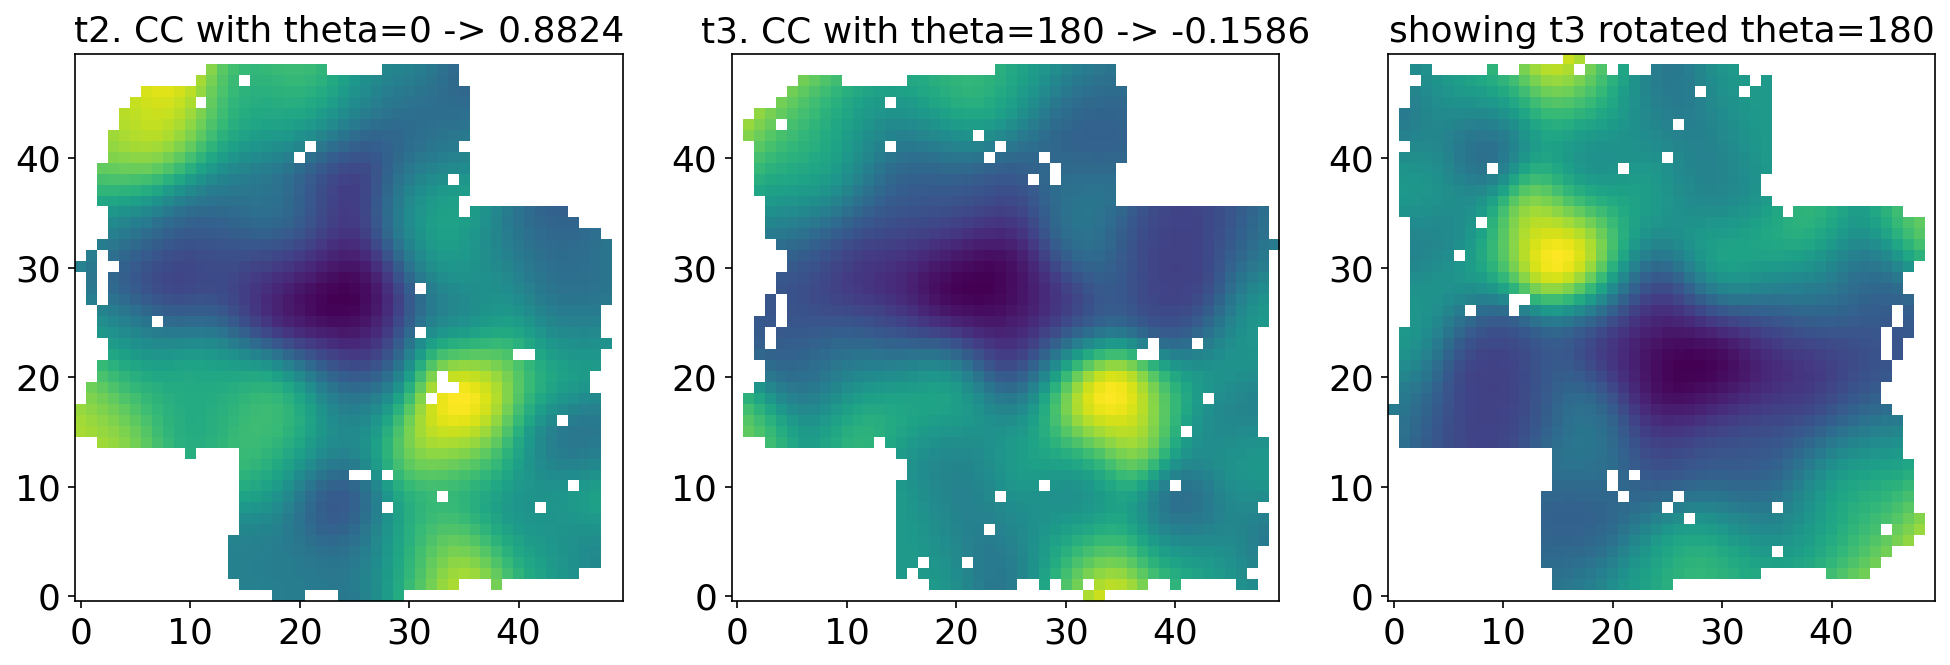

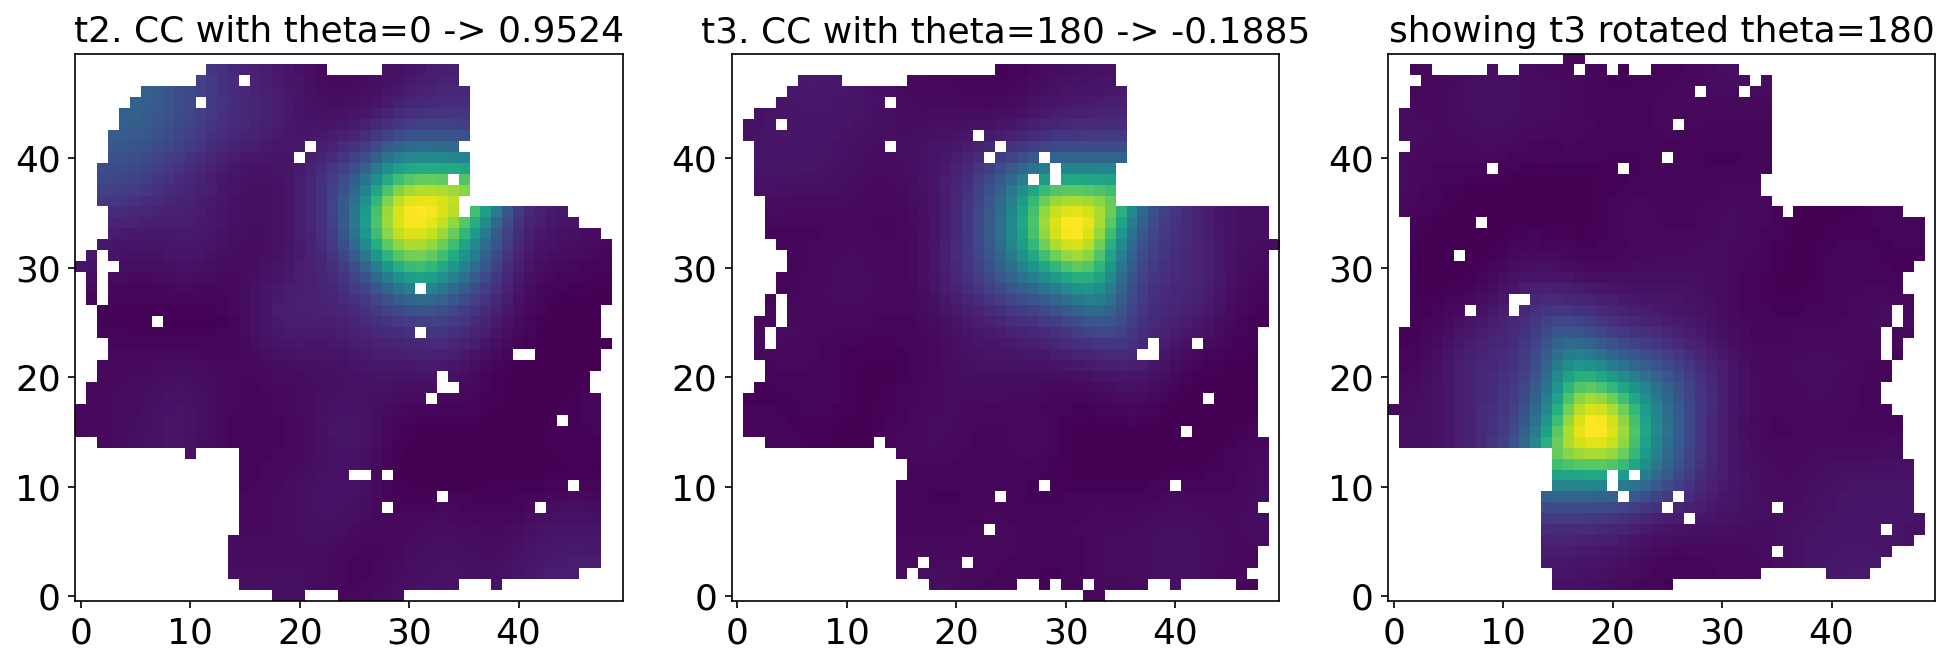

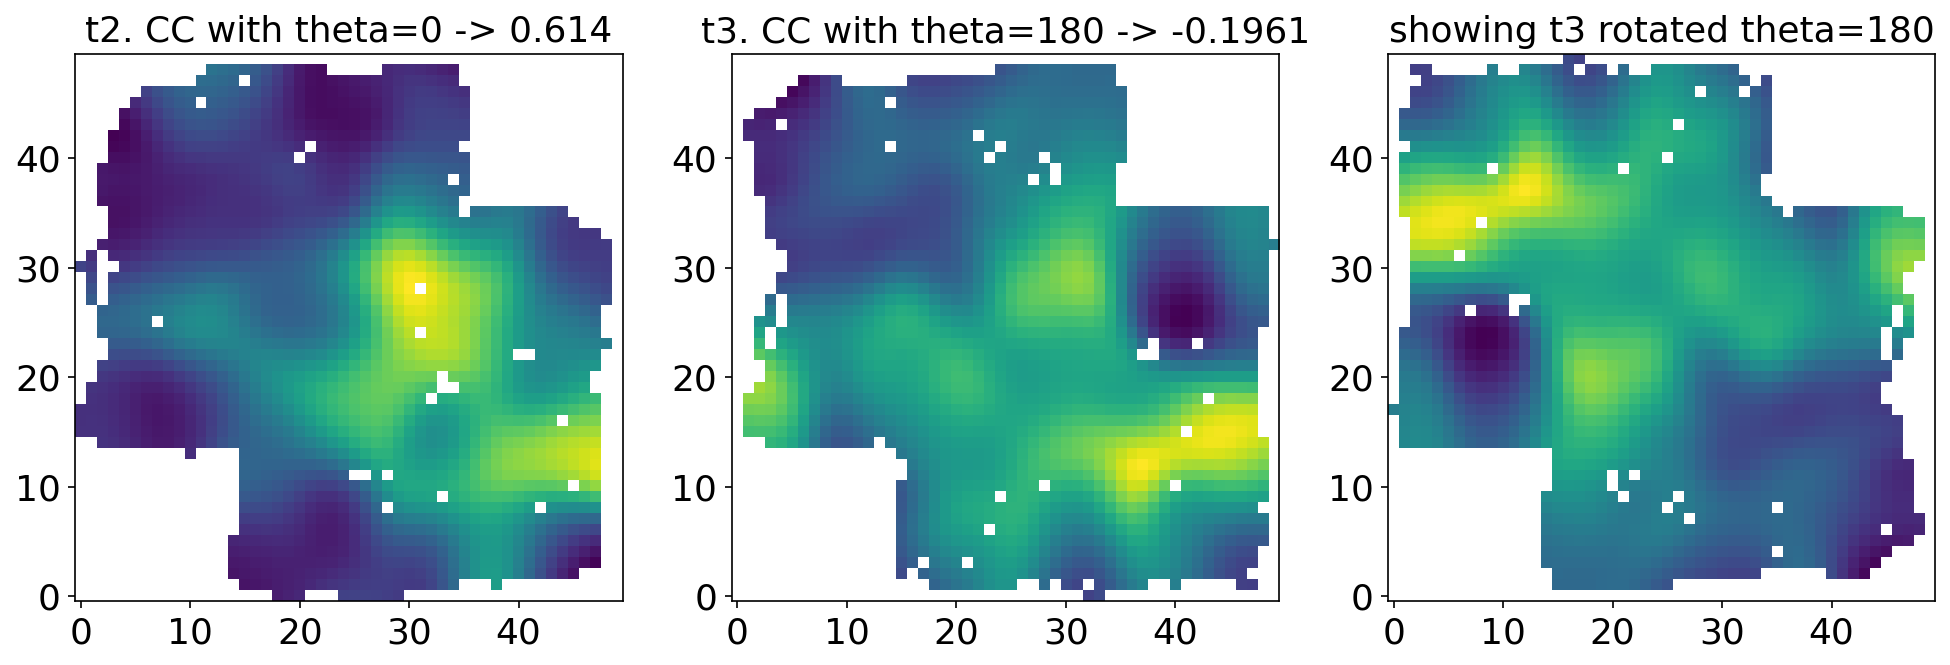

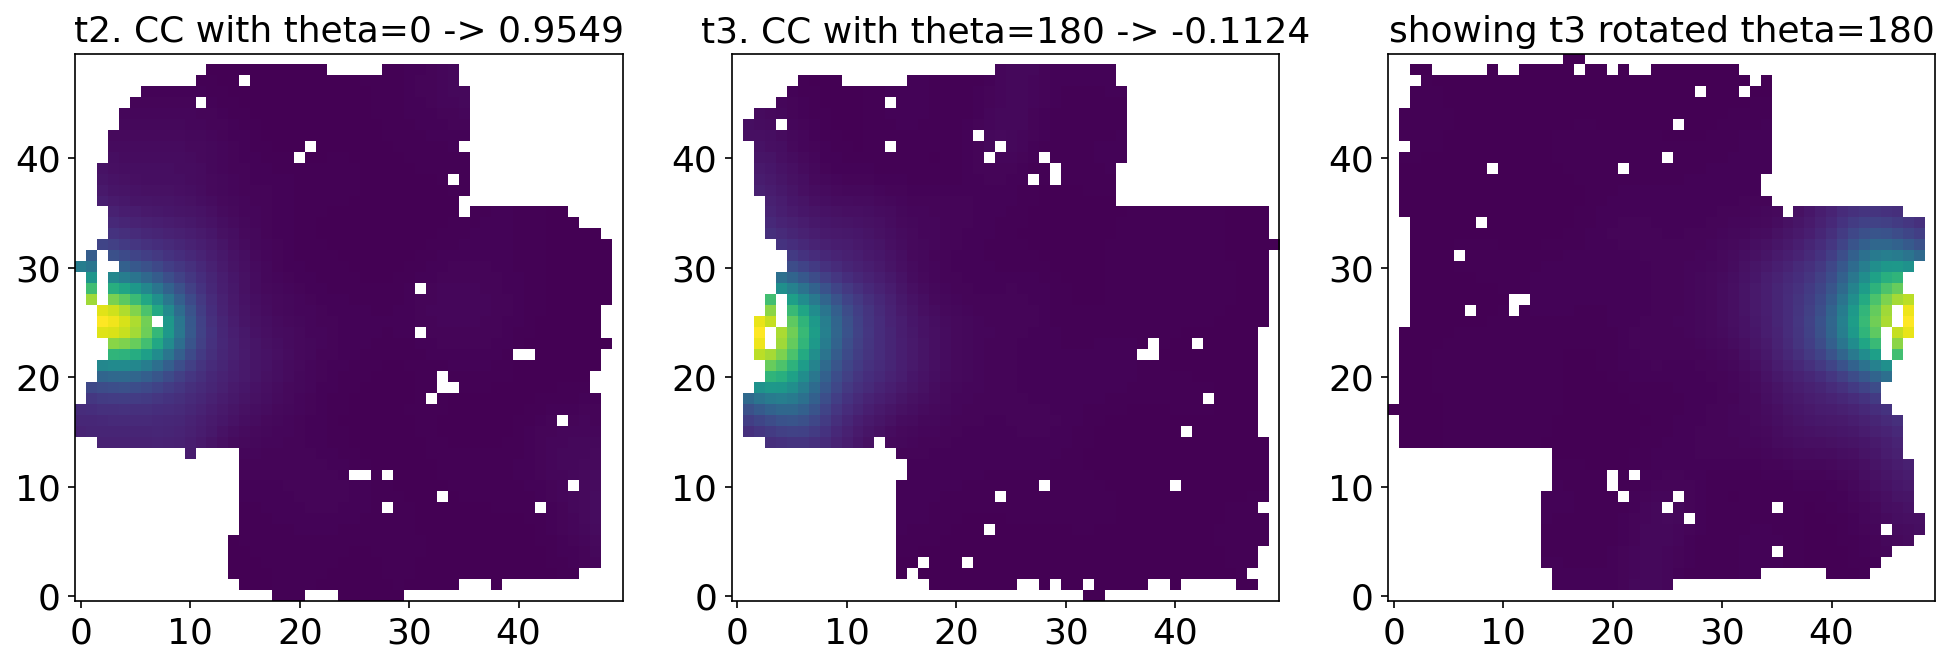

In [37]:
for i, unit_id in enumerate(punits):
    fig, ax = plt.subplots(ncols=3)
    ax[0].imshow(ratemaps[t2_action_id][unit_id],origin='lower')
    ax[0].set_title(f't2. CC with theta=0 -> {round(list(t2_vs_t3_stability.values())[0][i],4)}')
    ax[1].imshow(ratemaps[t3_action_id][unit_id],origin='lower')
    ax[1].set_title(f't3. CC with theta=180 -> {round(list(t2_vs_t3_stability.values())[1][i],4)}')
    ax[2].imshow(ratemaps[t3_action_id][unit_id][::-1,::-1],origin='lower') # 180 degree rotation by flipping on axes
    ax[2].set_title('showing t3 rotated theta=180')